<a href="https://colab.research.google.com/github/yelmokht/nuclei-segmentation/blob/main/nuclei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # 0. Constants, parameters and paths

In [ ]:
ROOT_PATH = '/content/'
DRIVE_PATH = ROOT_PATH + "drive/MyDrive/Colab Notebooks/"
SOURCE_PATH = DRIVE_PATH + 'data-science-bowl-2018.zip'
UNZIPPED_PATH = ROOT_PATH + 'unzipped/'
DESTINATION_PATH = DATA_PATH = ROOT_PATH + 'dsb_2018/'
TRAIN_PATH = DATA_PATH + 'stage1_train/'
TEST_1_PATH = DATA_PATH + 'stage1_test/'
TEST_2_PATH = DATA_PATH + 'stage2_test/'
STAGE_1_PATH = DATA_PATH + 'stage1_test/'
STAGE_2_PATH = DATA_PATH + 'stage2_test/'
STAGE_1_SOLUTION_PATH = DATA_PATH + 'stage1_solution/stage1_solution.csv'
STAGE_2_SOLUTION_PATH = DATA_PATH + 'stage2_solution/stage2_solution.csv'
IMAGE_HEIGHT = MASK_HEIGHT = 256
IMAGE_WIDTH = MASK_WIDTH = 256
IMAGE_NUM_CHANNELS = 3
MASK_NUM_CHANNELS = 1
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_NUM_CHANNELS)
MASK_SHAPE = (MASK_HEIGHT, MASK_WIDTH, MASK_NUM_CHANNELS)
INPUT_SHAPE = IMAGE_SHAPE
SEED = 42
BATCH_SIZE = 32
EPOCHS = 100
SAVE_MODEL_PATH = DRIVE_PATH + f'model_{EPOCHS}.keras'
SAVE_HISTORY_PATH = DRIVE_PATH + f'model_{EPOCHS}_history.csv'
LOAD_MODEL_PATH = DRIVE_PATH + f'model_{EPOCHS}.keras'
LOAD_HISTORY_PATH = DRIVE_PATH + f'model_{EPOCHS}_history.csv'
BEST_MODEL_PATH = DRIVE_PATH + 'model/' + 'model.h5'
BEST_HISTORY_PATH = DRIVE_PATH + 'model/' + 'history.csv'
SUBMISSION_PATH = DRIVE_PATH + 'submission.csv'
SOLUTION_PATH = DRIVE_PATH + 'solution.csv'

> # 1. Unzip the dataset and structure the data

In [ ]:
import os
import shutil
from zipfile import ZipFile

def unzip_and_structure_data(source_path, unzipped_path, destination_path):
    # Unzip files from source to unzipped
    if not os.path.exists(unzipped_path):
        with ZipFile(source_path, 'r') as zip_ref:
            zip_ref.extractall(unzipped_path)
        print("Files unzipped successfully.")
    else:
        print("Unzipped files already exist.")

    # Structure data from unzipped to destination
    if not os.path.exists(destination_path):
        for root, dirs, files in os.walk(unzipped_path):
            for filename in files:
                if filename.endswith(".zip"):
                    zip_file_path = os.path.join(root, filename)
                    output_folder = os.path.join(destination_path, os.path.splitext(filename)[0])
                    with ZipFile(zip_file_path, 'r') as zip_ref:
                        zip_ref.extractall(output_folder)
                    print(f"Unzipped {filename} to {output_folder}")
        print("Data files structured successfully.")
    else:
        print("Data files already exist.")

In [ ]:
unzip_and_structure_data(SOURCE_PATH, UNZIPPED_PATH, DESTINATION_PATH)

Files unzipped successfully.
Unzipped stage2_test.zip to /content/dsb_2018/stage2_test
Unzipped stage1_train.zip to /content/dsb_2018/stage1_train
Unzipped stage1_train_labels.zip to /content/dsb_2018/stage1_train_labels
Unzipped stage2_solution.zip to /content/dsb_2018/stage2_solution
Unzipped stage2_sample_submission.zip to /content/dsb_2018/stage2_sample_submission
Unzipped stage1_test.zip to /content/dsb_2018/stage1_test
Unzipped stage1_sample_submission.zip to /content/dsb_2018/stage1_sample_submission
Unzipped stage1_solution.zip to /content/dsb_2018/stage1_solution
Data files structured successfully.


> # 2. Decode RLE masks for each stage and save them

In [ ]:
import numpy as np
import pandas as pd
import os
from skimage.io import imsave
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

def rle_decode(rle_list, mask_shape, mask_dtype):
    masks = []
    for j, rle in enumerate(rle_list):
        mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
        s = rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[lo:hi] = 255
        masks.append(mask.reshape(mask_shape[::-1]).T)
    return np.array(masks)

def rle_to_masks(csv_path):
    gt_masks = {}
    df = pd.read_csv(csv_path, sep=',')
    image_ids = sorted(list(df['ImageId'].unique()))

    for image_id in image_ids:
        mask_rles = df.loc[df['ImageId'] == image_id]
        rle_list = mask_rles['EncodedPixels']
        heigth, width = pd.unique(mask_rles['Height'])[0], pd.unique(mask_rles['Width'])[0]
        masks = rle_decode(rle_list=rle_list, mask_shape=(heigth, width), mask_dtype=np.uint16)
        gt_masks[image_id] = masks

    return gt_masks

def save_masks(source_path, destination_path, stage):
    # Load masks
    gt_masks = rle_to_masks(source_path)

    # Iterate over each key in gt_masks
    for folder_id, masks in tqdm(gt_masks.items(), desc=f'{stage} images'):
        folder_path = os.path.join(destination_path, str(folder_id))
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Destination folder '{folder_path}' does not exist.")

        # Create masks folder inside the folder
        masks_folder_path = os.path.join(folder_path, 'masks')
        if not os.path.exists(masks_folder_path):
            os.makedirs(masks_folder_path)  # Create masks folder if it doesn't exist
            # Iterate over each value in gt_masks[key] (list of masks)
            for idx, mask in enumerate(masks):
                # Save mask as an image file in the masks folder
                mask_filename = f'{folder_id}_{idx}.png'
                mask_file_path = os.path.join(masks_folder_path, mask_filename)
                imsave(mask_file_path, mask)

    print(f'{stage} masks successfully saved !')

def remove_ignored_images_masks(csv_path, destination_path):
    df = pd.read_csv(csv_path)
    ignore_images = df.loc[df['Usage'] == 'Ignored', 'ImageId'].tolist()

    for image_id in ignore_images:
        folder_path = os.path.join(destination_path, image_id)
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
        else:
            print(f"Folder '{folder_path}' doesn't exist.")
        df = df[df['ImageId'] != image_id]

    df.to_csv(csv_path, index=False)
    print('stage2_solution.csv updated !')
    print('Images and masks of stage 2 updated !')

In [ ]:
save_masks(STAGE_1_SOLUTION_PATH, STAGE_1_PATH, 'Stage 1')
save_masks(STAGE_2_SOLUTION_PATH, STAGE_2_PATH, 'Stage 2')
remove_ignored_images_masks(STAGE_2_SOLUTION_PATH, TEST_2_PATH)

Stage 1 images:   0%|          | 0/65 [00:00<?, ?it/s]

Stage 1 masks successfully saved !


Stage 2 images:   0%|          | 0/3019 [00:00<?, ?it/s]

Stage 2 masks successfully saved !
stage2_solution.csv updated !
Images and masks of stage 2 updated !


> # 3. Load the data

In [ ]:
from skimage.io import imread
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from skimage.measure import regionprops, label
from skimage.transform import resize

def read_image(image_path):
    return imread(image_path).astype(np.uint8)

def binary_mask(id):
    masks_paths = glob(id + '/masks/*.png')
    masks = np.array([read_image(mask_path) for mask_path in masks_paths])
    num_masks, height, width = masks.shape
    binary_mask = np.zeros((height, width), np.uint8)
    for index in range(0, num_masks):
        binary_mask[masks[index] > 0] = 255
    return binary_mask

def load_data(train_path, test_1_path, test_2_path):
    train_image_paths = sorted(glob(train_path + '*/images/*.png'))
    test_1_image_paths = sorted(glob(test_1_path + '*/images/*.png'))
    test_2_image_paths = sorted(glob(test_2_path + '*/images/*.png'))

    train_ids = [path.rsplit('/', 2)[0] for path in train_image_paths]
    test_1_ids = [path.rsplit('/', 2)[0] for path in test_1_image_paths]
    test_2_ids = [path.rsplit('/', 2)[0] for path in test_2_image_paths]

    train_images = [read_image(image_path) for image_path in tqdm(train_image_paths, desc='Train images')]
    test_1_images = [read_image(image_path) for image_path in tqdm(test_1_image_paths, desc='Test images (stage 1)')]
    test_2_images = [read_image(image_path) for image_path in tqdm(test_2_image_paths, desc='Test images (stage 2)')]

    train_masks = [binary_mask(id) for id in tqdm(train_ids, desc='Train masks')]
    test_1_masks = [binary_mask(id) for id in tqdm(test_1_ids, desc='Test masks (stage 1)')]
    test_2_masks = [binary_mask(id) for id in tqdm(test_2_ids, desc='Test masks (stage 2)')]

    train_images += test_1_images
    train_masks += test_1_masks

    return train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks

In [ ]:
train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks = load_data(TRAIN_PATH, TEST_1_PATH, TEST_2_PATH)

Train images:   0%|          | 0/670 [00:00<?, ?it/s]

Test images (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test images (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

Train masks:   0%|          | 0/670 [00:00<?, ?it/s]

Test masks (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test masks (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

> # 4. Visualize the data

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Layout

def plot_images(train_images, train_masks, test_1_images, test_1_masks, test_2_images, test_2_masks):
    @interact(index_0=IntSlider(min=0, max=len(train_images)-1, continuous_update=False, description='Train index'),
              index_1=IntSlider(min=0, max=len(test_1_images)-1, continuous_update=False, description='Test 1 index'),
              index_2=IntSlider(min=0, max=len(test_2_images)-1, continuous_update=False, description='Test 2 index'))
    def update_plot(index_0, index_1, index_2):
        fig, axes = plt.subplots(2, 3, figsize=(18, 8), layout='compressed')

        axes[0, 0].imshow(train_images[index_0])
        axes[0, 0].set_title(f'Train image n°{index_0}')
        axes[1, 0].imshow(train_masks[index_0])
        axes[1, 0].set_title(f'Train mask n°{index_0}')

        axes[0, 1].imshow(test_1_images[index_1])
        axes[0, 1].set_title(f'Test 1 image n°{index_1}')
        axes[1, 1].imshow(test_1_masks[index_1])
        axes[1, 1].set_title(f'Test 1 mask n°{index_1}')

        axes[0, 2].imshow(test_2_images[index_2])
        axes[0, 2].set_title(f'Test 2 image n°{index_2}')
        axes[1, 2].imshow(test_2_masks[index_2])
        axes[1, 2].set_title(f'Test 2 mask n°{index_2}')

        plt.show()

In [ ]:
plot_images(train_images, train_masks, test_1_images, test_1_masks, test_2_images, test_2_masks)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Train index', max=734), IntSlid…

> # 5. Analyze the data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_data(train_images, test_1_images, test_2_images):
    train_sizes = [(image.shape[0], image.shape[1]) for image in train_images]
    test_1_sizes = [(image.shape[0], image.shape[1]) for image in test_1_images]
    test_2_sizes = [(image.shape[0], image.shape[1]) for image in test_2_images]

    all_sizes = train_sizes + test_1_sizes + test_2_sizes
    unique_sizes, counts = np.unique(all_sizes, return_counts=True, axis=0)
    unique_sizes = [tuple(size) for size in unique_sizes]

    fig, ax = plt.subplots(figsize=(10, 6))

    for label, sizes in zip(['Train', 'Test 1', 'Test 2'], [train_sizes, test_1_sizes, test_2_sizes]):
        sizes_flat = np.array(sizes)
        sizes_tuples = [tuple(size) for size in sizes_flat]
        counts = Counter(sizes_tuples)
        ax.bar(range(len(unique_sizes)), [counts[size_tuple] for size_tuple in unique_sizes], alpha=0.5, label=label)

    ax.set_title('Image Sizes Distribution')
    ax.set_xlabel('Image size (height x width)')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(unique_sizes)))
    ax.set_xticklabels([f"{size[0]}x{size[1]}" for size in unique_sizes], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

    most_common_overall = Counter(tuple(map(tuple, all_sizes))).most_common(1)[0][0]

    most_common = {
        "Train set": Counter(tuple(map(tuple, train_sizes))).most_common(1)[0][0],
        "Test 1 set": Counter(tuple(map(tuple, test_1_sizes))).most_common(1)[0][0],
        "Test 2 set": Counter(tuple(map(tuple, test_2_sizes))).most_common(1)[0][0],
        "Overall": most_common_overall
    }

    for set_name, size in most_common.items():
        print(f"Most common size in {set_name}:", size)

    return most_common_overall


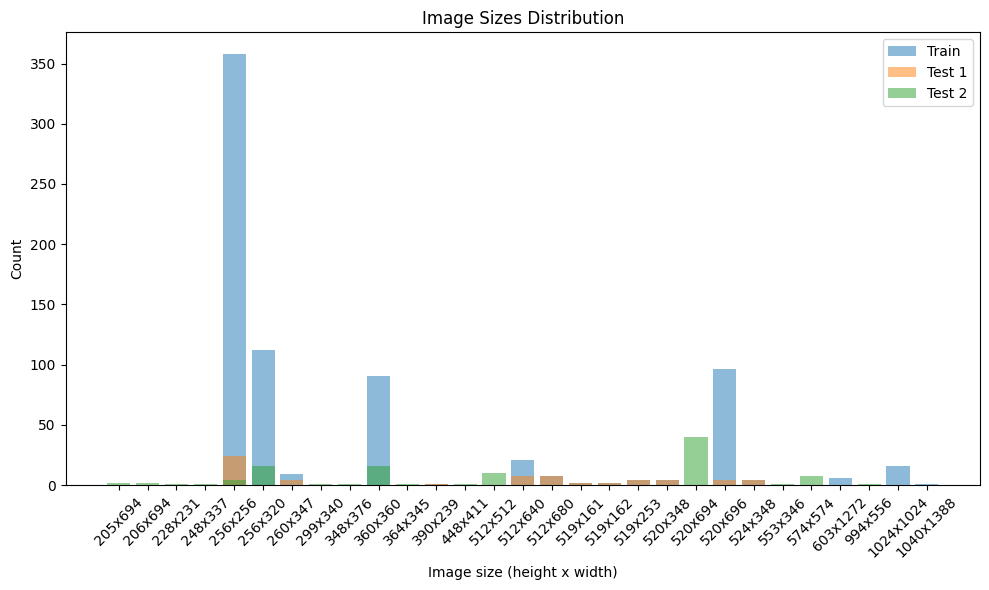

Most common size in Train set: (256, 256)
Most common size in Test 1 set: (256, 256)
Most common size in Test 2 set: (520, 694)
Most common size in Overall: (256, 256)


(256, 256)

In [ ]:
analyze_data(train_images, test_1_images, test_2_images)

> # 6. Preprocess the data

In [ ]:
from skimage.transform import resize
from skimage.color import rgb2gray

def preprocess(image, shape, param=False):
    processed_image = None

    if shape[2] == 3:
        if len(image.shape) == 3 and image.shape[2] >= shape[2]:
            processed_image = resize(image[:, :, :shape[2]], (shape[0], shape[1])).astype(np.float32)
        else:
            print(image.shape)
            processed_image = np.repeat(image[:, :, np.newaxis], 3, axis=-1)
            print(processed_image.shape)
            processed_image = resize(processed_image[:, :, :shape[2]], (shape[0], shape[1])).astype(np.float32)

    if shape[2] == 1:
        processed_image = resize(image, (shape[0], shape[1])).astype(np.float32)
        if param == False:
            processed_image = np.expand_dims(processed_image, axis=-1)

    return processed_image.astype(np.float32)

def preprocess_data(train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks):
    train_images = np.array([preprocess(image, IMAGE_SHAPE) for image in tqdm(train_images, desc='Preprocess train images')])
    test_1_images = np.array([preprocess(image, IMAGE_SHAPE) for image in tqdm(test_1_images, desc='Preprocess test images (stage 1)')])
    test_2_images = np.array([preprocess(image, IMAGE_SHAPE) for image in tqdm(test_2_images, desc='Preprocess test images (stage 2)')])
    train_masks = np.array([preprocess(mask, MASK_SHAPE) for mask in tqdm(train_masks , desc='Preprocess train masks')])
    test_1_masks = np.array([preprocess(mask, MASK_SHAPE) for mask in tqdm(test_1_masks, desc='Preprocess test masks (stage 1)')])
    test_2_masks = np.array([preprocess(mask, MASK_SHAPE) for mask in tqdm(test_2_masks, desc='Preprocess test masks (stage 2)')])
    return train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks


In [ ]:
pp_train_images, pp_test_1_images, pp_test_2_images, pp_train_masks, pp_test_1_masks, pp_test_2_masks = preprocess_data(train_images, test_1_images, test_2_images, train_masks, test_1_masks, test_2_masks)

Preprocess train images:   0%|          | 0/735 [00:00<?, ?it/s]

Preprocess test images (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Preprocess test images (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

Preprocess train masks:   0%|          | 0/735 [00:00<?, ?it/s]

Preprocess test masks (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Preprocess test masks (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

> # 7. Visualize preprocessed data

In [ ]:
plot_images(pp_train_images, pp_train_masks, pp_test_1_images, pp_test_1_masks, pp_test_2_images, pp_test_2_masks)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Train index', max=734), IntSlid…

> # 8. Setup train, val and test set

In [ ]:
from sklearn.model_selection import train_test_split

def train_val_split(train_images, train_masks, ratio):
    return train_test_split(train_images, train_masks, test_size=ratio, random_state=0)

In [ ]:
pp_train_images, pp_val_images, pp_train_masks, pp_val_masks = train_val_split(pp_train_images, pp_train_masks, ratio=0.3)

> # 9. Data augmentation

In [ ]:
import random
from keras.preprocessing.image import ImageDataGenerator

def generate_augmented_data(train_images, train_masks, val_images, val_masks):
    img_data_gen_args = dict(rotation_range=90,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.3,
                        zoom_range=0.3,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='reflect'
                        )

    mask_data_gen_args = dict(rotation_range=90,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.3,
                        zoom_range=0.3,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='reflect',
                        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

    # Data augmentation
    image_data_generator = ImageDataGenerator(**img_data_gen_args)
    mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

    # Data augmentation
    image_data_generator.fit(train_images, augment=True, seed=SEED)
    mask_data_generator.fit(train_masks, augment=True, seed=SEED)

    # Train
    train_image_generator = image_data_generator.flow(train_images, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
    train_mask_generator = mask_data_generator.flow(train_masks, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

    # Val
    val_image_generator = image_data_generator.flow(val_images, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
    val_mask_generator = mask_data_generator.flow(val_masks, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

    # Generator
    train_generator = zip(train_image_generator, train_mask_generator)
    val_generator = zip(val_image_generator, val_mask_generator)

    steps_per_epoch = len(train_image_generator)
    validation_steps = len(val_image_generator)

    print('Batch size: ', BATCH_SIZE)
    print('Steps per epoch: ', steps_per_epoch)
    print('Validation steps: ', validation_steps)

    return train_generator, val_generator, steps_per_epoch, validation_steps

In [ ]:
train_generator, val_generator, steps_per_epoch, validation_steps = generate_augmented_data(pp_train_images, pp_train_masks, pp_val_images, pp_val_masks)

Batch size:  32
Steps per epoch:  17
Validation steps:  7


> # 10. Visualize augmented data

In [ ]:
def visualize_augmented_data(train_generator, val_generator, steps_per_epoch, validation_steps):
    batch_size = BATCH_SIZE
    num_cols = 4

    @interact(batch_num=IntSlider(min=0, max=min(steps_per_epoch - 1, validation_steps - 1), continuous_update=False, description='Batch number'))
    def update_plot(batch_num):
        fig, axes = plt.subplots(8, 8, figsize=(32, 32))


        for i, (train_images_batch, _) in enumerate(train_generator):
            if i == batch_num:
                break

        for i, (val_images_batch, _) in enumerate(val_generator):
            if i == batch_num:
                break

        for i in range(batch_size):
            row = i // num_cols
            col = i % num_cols
            axes[row, col].imshow(train_images_batch[i])
            axes[row, col].set_title(f'Train image n°{i}')

            axes[row, col + num_cols].imshow(val_images_batch[i])
            axes[row, col + num_cols].set_title(f'Val image n°{i}')

        plt.show()

In [ ]:
visualize_augmented_data(train_generator, val_generator, steps_per_epoch, validation_steps)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Batch number', max=6), Output()…

> # 11. U-Net model

In [ ]:
!pip install tensorflow-addons
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation
from keras.layers import MaxPool2D
from keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import MeanIoU
!pip install segmentation-models
from tensorflow import keras
from keras.optimizers import Adam, SGD
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models.losses import bce_jaccard_loss, JaccardLoss, bce_dice_loss
from segmentation_models.metrics import IOUScore, FScore, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import pandas as pd

# Convolution block
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

# Encoder block = convolution block + max pooling
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D((2, 2))(x)
  return x, p

# Decoder block = upsampling + concatenation + convolution block
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

  model = Model(inputs, outputs, name="U-Net")
  return model

def jaccard_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1,2)) - intersection
    jaccard = (intersection + 1e-15) / (union + 1e-15)
    return 1 - tf.reduce_mean(jaccard)

def unet_model():
    model = unet(INPUT_SHAPE)
    model.compile(optimizer=Adam(), loss=jaccard_loss, metrics=[IoU(), 'accuracy', Precision(), Recall(), F1Score()])
    # model.summary()
    return model

def modified_unet_model():
    model = sm.Unet()
    model.compile(optimizer=Adam(), loss = JaccardLoss(), metrics=[IOUScore(), 'accuracy', FScore(beta=1), Precision(), Recall()])
    # model.summary()
    return model

def save_history(history, file_path):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(file_path, index=False)
    history = history_df.to_dict(orient='list')
    return history

def train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, path):
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', filepath=f'model_checkpoint_{EPOCHS}.h5', save_best_only=True)
    history = model.fit_generator(train_generator,
                                validation_data=val_generator,
                                steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps,
                                epochs=EPOCHS,
                                callbacks=[checkpoint_callback])

    if not os.path.exists(path):
        model.save(path)
        history = save_history(history, SAVE_HISTORY_PATH)
    else:
        print(f"Model already exists at {path}. Skipping saving.")
    return history

def load_history(file_path):
    history_df = pd.read_csv(file_path)
    history = history_df.to_dict(orient='list')
    return history

def load_unet_model(model_path, history_path):
    model = load_model(model_path, compile=False)
    history = load_history(history_path)
    return model, history

In [ ]:
parameter = 'load'
model = None
history = None
if parameter == 'train':
    model = modified_unet_model()
    history = train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, SAVE_MODEL_PATH)
else:
    model, history = load_unet_model(BEST_MODEL_PATH, BEST_HISTORY_PATH)

> # 12. Visualize model history

In [ ]:
def print_plot_history(history):
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    plt.plot(history['iou_score'], label='Train Iou')
    plt.plot(history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history['val_iou_score'], label='Val Iou')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['precision'], label='Train Precision')
    plt.plot(history['recall'], label='Train Recall')
    plt.plot(history['f1-score'], label='Train F1 Score')
    plt.title('Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.plot(history['val_precision'], label='Val Precision')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.plot(history['val_f1-score'], label='Val F1 Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

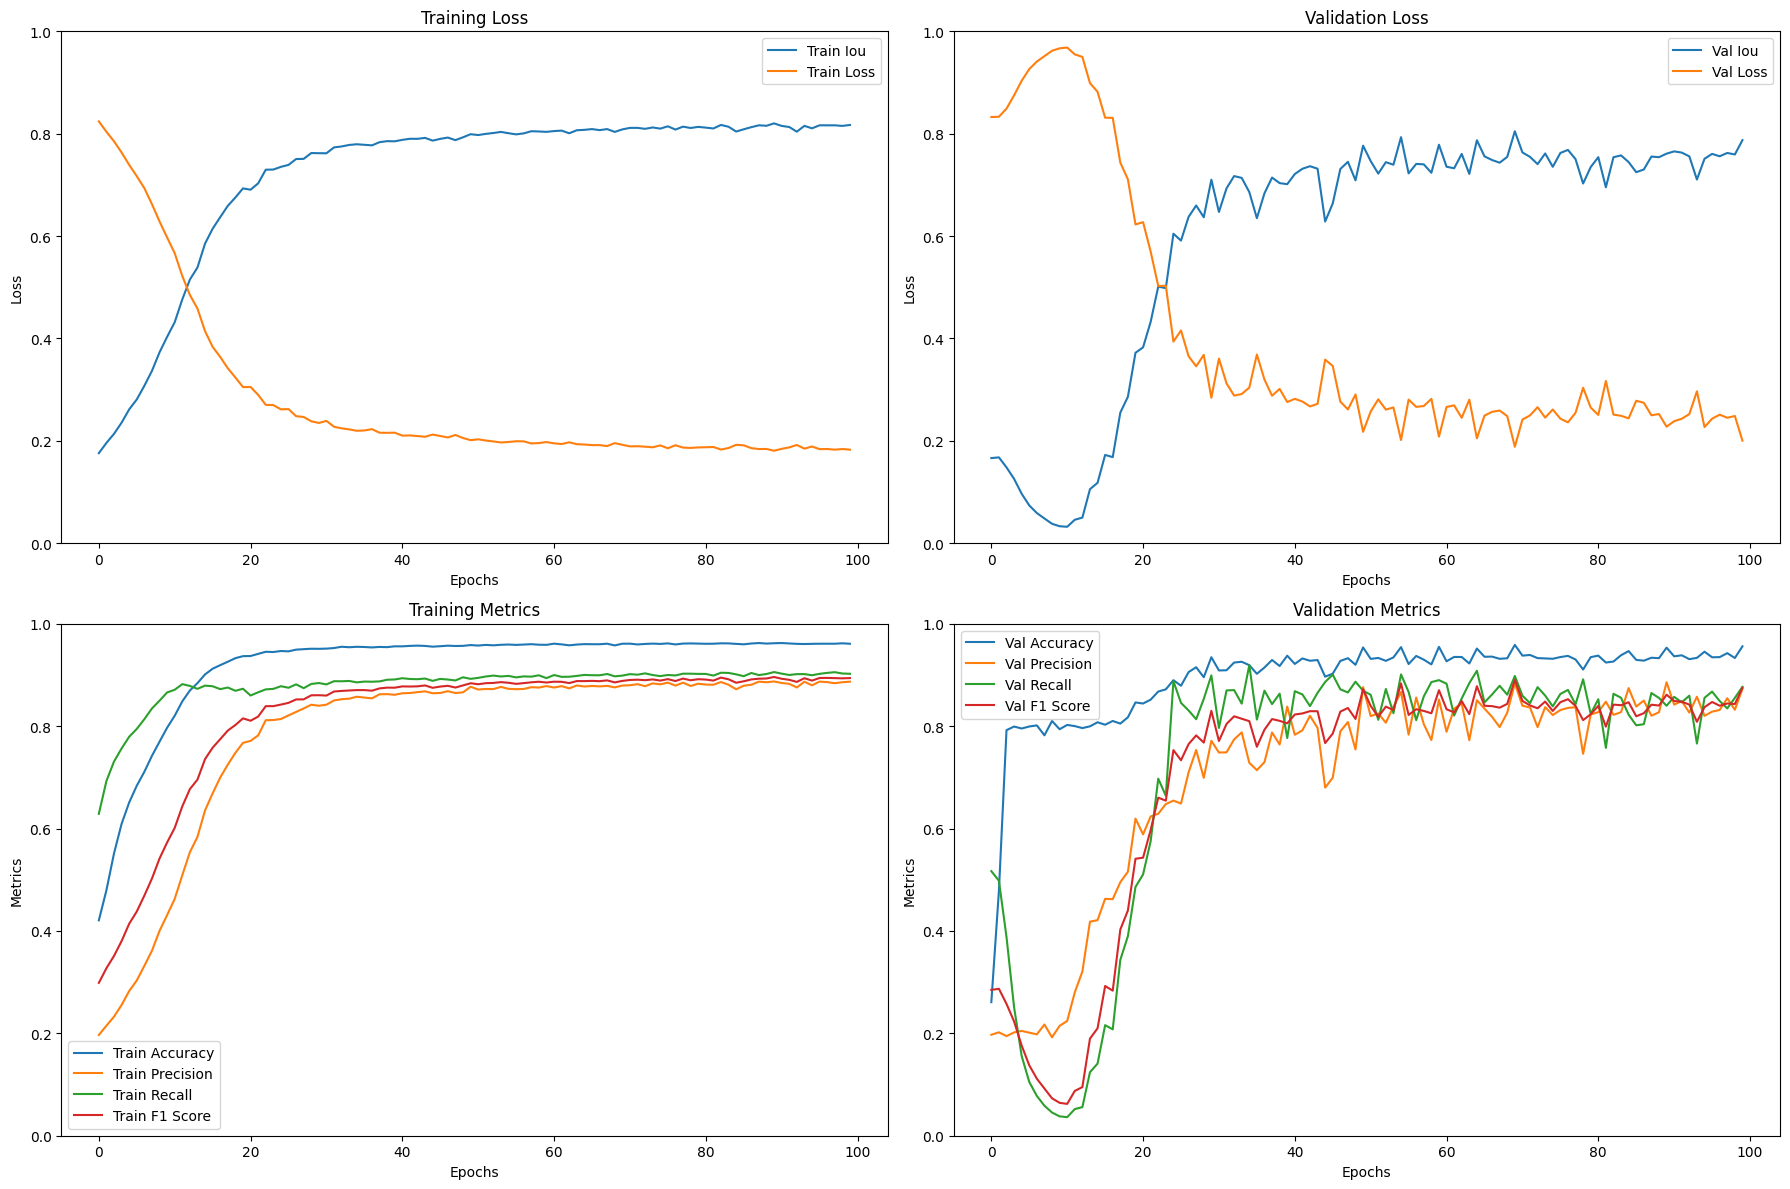

In [ ]:
print_plot_history(history)

> # 13. Test time augmentation (TTA)

In [ ]:
from skimage.filters import threshold_otsu

def tta(model, images):
    tta_masks = []
    for image in tqdm(images, desc='TTA for test images (stage 2)'):
        tta_predictions = []
        original_prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)
        tta_predictions.append(np.squeeze(original_prediction))

        for angle in range(90, 360, 90):
            rotated_image = np.rot90(image, k=angle // 90)
            rotated_prediction = model.predict(np.expand_dims(rotated_image, axis=0), verbose=0)
            tta_predictions.append(np.rot90(np.squeeze(rotated_prediction), k=-angle // 90))

        # Horizontal flip
        horizontal_flip = np.fliplr(image)
        horizontal_flip_prediction = model.predict(np.expand_dims(horizontal_flip, axis=0), verbose=0)
        tta_predictions.append(np.fliplr(np.squeeze(horizontal_flip_prediction)))

        # Vertical flip
        # vertical_flip = np.flipud(image)
        # vertical_flip_prediction = model.predict(np.expand_dims(vertical_flip, axis=0), verbose=0)
        # tta_predictions.append(np.flipud(np.squeeze(vertical_flip_prediction)))

        # Mean aggregation
        mean_prediction = np.expand_dims(np.mean(tta_predictions, axis=0), axis=-1)

        # Thresholding (example using Otsu's method)
        mean_mask = (mean_prediction > threshold_otsu(mean_prediction)).astype(np.uint8)

        tta_masks.append(mean_mask)

    return np.array(tta_masks)

In [ ]:
# test_1_pred_masks = tta(model, test_1_images)
test_2_pred_masks = tta(model, pp_test_2_images)

TTA for test images (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

> # 14. Post processing

In [ ]:
import numpy as np
from skimage import morphology, measure, color, segmentation
from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage import morphology
from skimage import segmentation
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import sobel,gaussian
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt, binary_fill_holes
from skimage.filters.rank import gradient
from skimage.morphology import disk, closing, binary_opening, opening, binary_dilation, binary_erosion, binary_closing, thin, erosion
from skimage.segmentation import watershed, mark_boundaries, random_walker, clear_border, join_segmentations
import skimage.morphology

def post_proccess_masks(test_pred_masks):
    test_pp_masks = []
    for idx, mask in enumerate(tqdm(test_pred_masks, desc='Post processing of predictions')):
        mask = np.squeeze(mask)
        mask = mask > threshold_otsu(mask)
        mask = binary_fill_holes(mask).astype(np.uint8)
        regions = regionprops(label(mask))
        radii = []
        for region in regions:
            radius = np.sqrt(region.area / np.pi)
            radii.append(radius)
        average_radius = int(round(np.mean(radii)))
        distance = distance_transform_edt(mask)
        markers = label(peak_local_max(distance, min_distance=average_radius, footprint=disk(average_radius), threshold_rel=0.2, indices=False, exclude_border=False)) #min distance to determine
        wsh = watershed(-distance, markers, mask=mask)
        # markers[mask == 0] = -1
        # rw = random_walker(mask, markers)
        # rw[rw <= 0] = 0
        test_pp_masks.append(wsh)

    return np.array(test_pp_masks)

def post_proccess_masks_2(test_pred_masks, markers):
    test_pp_masks = []
    for idx, mask in enumerate(test_pred_masks):
        mask = np.squeeze(mask)
        distance = distance_transform_edt(mask)
        m2 = markers[idx]
        wsh = watershed(-distance, m2, mask=mask)
        # markers[mask == 0] = -1
        # rw = random_walker(mask, markers)
        # rw[rw <= 0] = 0
        test_pp_masks.append(wsh)

    return np.array(test_pp_masks)

In [ ]:
# test_1_pp_masks = post_proccess_masks(test_1_pred_masks)
test_2_pp_masks = post_proccess_masks(test_2_pred_masks)

Post processing of predictions:   0%|          | 0/106 [00:00<?, ?it/s]

<ipython-input-30-65e60a6ef4bd>:29: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  markers = label(peak_local_max(distance, min_distance=average_radius, footprint=disk(average_radius), threshold_rel=0.2, indices=False, exclude_border=False)) #min distance to determine


> # 15. Load solution

In [ ]:
def labeled_mask(id):
    masks_paths = glob(id + '/masks/*.png')
    masks =  np.array([read_image(mask_path) for mask_path in masks_paths])
    masks = np.array([preprocess(mask, MASK_SHAPE, param=True) for mask in masks])
    num_masks, height, width = masks.shape
    labeled_mask = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labeled_mask[masks[index] > 0] = index + 1
    return labeled_mask

def markers(id):
    masks_paths = glob(id + '/masks/*.png')
    masks = np.array([read_image(mask_path) for mask_path in masks_paths])
    markers = []
    for mask in masks:
        mask = preprocess(mask, MASK_SHAPE, param=True)
        labeled_mask = label(mask)
        regions = regionprops(labeled_mask)
        for region in regions:
            center_row, center_col = region.centroid
            markers.append([center_row, center_col])
    markers = np.array(markers)
    return markers

def load_solution(test_1_path, test_2_path):
    test_1_image_paths = sorted(glob(test_1_path + '*/images/*.png'))
    test_2_image_paths = sorted(glob(test_2_path + '*/images/*.png'))

    test_1_ids = [path.rsplit('/', 2)[0] for path in test_1_image_paths]
    test_2_ids = [path.rsplit('/', 2)[0] for path in test_2_image_paths]

    test_1_labels = [labeled_mask(id) for id in tqdm(test_1_ids, desc='Test labels (stage 1)')]
    test_2_labels = [labeled_mask(id) for id in tqdm(test_2_ids, desc='Test labels (stage 2)')]

    test_1_markers = [markers(id) for id in tqdm(test_1_ids, desc='Test markers (stage 1)')]
    test_2_markers = [markers(id) for id in tqdm(test_2_ids, desc='Test markers (stage 2)')]

    return test_1_labels, test_2_labels, test_1_markers, test_2_markers

In [ ]:
test_1_labels, test_2_labels, test_1_markers, test_2_markers = load_solution(TEST_1_PATH, TEST_2_PATH)

Test labels (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test labels (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

Test markers (stage 1):   0%|          | 0/65 [00:00<?, ?it/s]

Test markers (stage 2):   0%|          | 0/106 [00:00<?, ?it/s]

> # 16. Evaluation

In [ ]:
import matplotlib.pyplot as plt
from skimage.measure import label

# https://www.kaggle.com/code/wcukierski/example-metric-implementation
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def score(masks, pred, verbose=True):
    labels = masks
    y_pred = pred

    # Compute number of objects
    true_objects = len(np.unique(labels)) # Background = 0
    pred_objects = len(np.unique(y_pred)) # Background = 0
    if verbose:
        print("Number of true objects:", true_objects - 1)
        print("Number of predicted objects:", pred_objects - 1)

    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Loop over IoU thresholds
    prec = []

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

> # 17. Results

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def show_results(images, gt_masks, labels, pred_masks, pp_masks, verbose=True):
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # (blue, white, red)
    cmap_name = 'custom_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors)

    scores = []
    for idx, (image, gt_mask, pred_mask, pp_mask) in enumerate(zip(images, gt_masks, pred_masks, pp_masks)):
        if verbose:
            fig, ax = plt.subplots(1, 4, figsize=(20, 20))

            ax[0].set_title(f'Image n°{idx}')
            ax[0].imshow(image)

            ax[1].set_title(f'Ground truth mask n°{idx}')
            ax[1].imshow(gt_mask)

            ax[2].set_title(f'Post processed mask n°{idx}')
            ax[2].imshow(np.expand_dims(pp_mask, axis=-1))

            a = np.squeeze(gt_masks[idx]) - (pp_masks[idx] > 0).astype(np.uint8)
            ax[3].set_title('Differences')
            ax[3].imshow(a, cmap=cm, vmin=-1, vmax=1)

        a = labels[idx]
        b = label(pp_mask)
        score_i = score(a, b, verbose=verbose)
        scores.append(score_i)
        plt.show()

    print(f'LB = {np.mean(scores)}')

In [ ]:
# show_results(test_1_images, test_1_masks, test_1_labels, test_1_pred_masks, test_1_pp_masks, verbose=False)
show_results(pp_test_2_images, pp_test_2_masks, test_2_labels, test_2_pred_masks, test_2_pp_masks, verbose=True)

> # 18. Submission

In [ ]:
# @title
!pip install --upgrade kaggle
import csv
from google.colab import files

# Run-length encoding taken from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(y):
    dots = np.where(y.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def pred_to_rles(y):
    for i in range(1, y.max() + 1):
        yield rle_encoding(y == i)

def create_submission(preds, submission_path):
    uuids = [path.rsplit('/', 2)[0] for path in sorted(glob(TEST_2_PATH + '*/images/*.png'))]
    original_shapes = [read_image(image_path).shape[:2] for image_path in sorted(glob(TEST_2_PATH + '*/images/*.png'))]
    with open(submission_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ImageId', 'EncodedPixels'])

        for idx, (uid, y) in tqdm(enumerate(zip(uuids, preds))):
            uid = os.path.basename(uid)
            y = label(erosion(y, footprint=disk(2)))
            y_resized = resize(y, (original_shapes[idx][0], original_shapes[idx][1]), mode='constant', order=0, preserve_range=True, anti_aliasing=True)
            for rle in pred_to_rles(y_resized):
                writer.writerow([uid, ' '.join([str(i) for i in rle])])

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
create_submission(test_2_pp_masks, SUBMISSION_PATH)
!kaggle competitions submit -c data-science-bowl-2018 -f "{SUBMISSION_PATH}" -m "Submission done with Colab"

0it [00:00, ?it/s]

100% 946k/946k [00:01<00:00, 554kB/s]
Successfully submitted to 2018 Data Science Bowl 